In [1]:
# Parallel processing
import ipyparallel as ipp

#DB
import os

# Helpers
import numpy as np
# import qgrid
from tqdm import tqdm_notebook
import time
import pandas as pd

# Preprocessing
from analyzer import python_analyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from vectorizer import NCutVectorizer

# Plots
import matplotlib.pyplot as plt

%matplotlib notebook

## Start parallel client

In [13]:
rc = ipp.Client()
dview = rc[:]
lbview = rc.load_balanced_view()
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

## Data

In [4]:
def get_docs(topics):
    docs = []
    base_path = "bbc"
    for t in topics:
        docs_title = os.listdir("%s/%s" % (base_path,t))
        for item in docs_title:
            with open('%s/%s/%s' %(base_path, t, item), 'r') as txtfile:
                try:
                    docs.append(txtfile.read())
                except UnicodeDecodeError:
                    print("Error on doc %s/%s" % (t,item))
    return docs

In [5]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = 'word',
                                          binary=binary,
                                          min_df=min_df)

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T


### Preprocessing solutions into bag of words ###

In [6]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
#     vectorizer = vectorizer_method(analyzer = python_analyzer,
    vectorizer = vectorizer_method(analyzer = 'word',
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features

In [10]:
def run_clusters(*args):
    # Import libraries
    # DB
    import psycopg2
    # Helpers
    import base64
    import pickle
    import time
    import numpy as np
    # Learning
    from clustering import Clustering
    # Evaluation
    from sklearn.metrics import silhouette_samples, silhouette_score
    from gap import Gap, define_k
    from coherence import calculate_umass_coherence
    
    # Get arguments
    dataset, v, m, b, train_data_features, k, dist, method = args
    
    # Instanciate objects
    clustering = Clustering(train_data_features, k, metric=dist)
    gap = Gap(train_data_features, k, nrefs=20, distance=dist)
    
    # Cluster
    start = time.time()
    model, document_topic, word_topic = getattr(clustering, method)()
    clusters = document_topic.argmax(axis=1)
    end = time.time()
    clustering_time = end-start

    # Compute Gap
    start = time.time()
    k_gap = gap.calculate_gap(clustering, method)
#     k_gap = [3,2]
    end = time.time()
    gap_time = end-start

    # Compute silhouette. Keep single to values to be able to plot it later
    start = time.time()
    k_silhouette = silhouette_score(train_data_features, clusters, metric=dist)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_data_features, clusters, metric=dist)
    end = time.time()
    silhouette_time = end-start

    # UMass coherence
    start = time.time()
    k_coherence = calculate_umass_coherence(train_data_features, word_topic, clusters, k)
    end = time.time()
    coherence_time = end-start

    row = {
        "dataset": dataset,
        "X": train_data_features,
        "y": clusters,
        "vectorizer": v.__name__,
        "is_binary": b,
        "min_df": m,
        "distance": dist,
        "k": k,
        "method": method,
        "model": base64.b64encode(pickle.dumps(model)),
        "clustering_time": clustering_time,
        "gap": k_gap[0],
        "gap_std": k_gap[1],
        "gap_time": gap_time,
        "silhouette": k_silhouette,
        "silhouette_samples": sample_silhouette_values,
        "silhouette_time": silhouette_time,
        "coherence_samples": k_coherence[0],
        "coherence_med": k_coherence[1],
        "coherence_std": k_coherence[2],
        "coherence_time": coherence_time,
        "coherence_k": len(k_coherence[0]),
    }
    
    # Connect to DB
    connection = psycopg2.connect(user = "machineteaching",
                                  password = "***REMOVED***",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
    connection.autocommit=True
    cursor = connection.cursor()

    # Write PSQL query
    insert_query_base = "INSERT INTO EXPERIMENTS "
    column_value = []
    insert_format = []
    query_values = []
    for col in row.keys():
        if isinstance(row[col], np.ndarray):
            query_values.append(row[col].tolist())
        else:
            query_values.append(row[col])
        column_value.append(col)
        insert_format.append("%s")

    insert_query = insert_query_base + "(" + ", ".join(column_value) + ") VALUES "
    insert_query += "(" + ", ".join(insert_format) + ")"
    query_values = tuple(query_values)
    query = cursor.mogrify(insert_query, query_values)
    cursor.execute(query)
    
    return row

In [ ]:
%%time

vectorizers = [CountVectorizer,
               TfidfVectorizer, 
               NCutVectorizer]
min_df = np.arange(0.05, 0.5, 0.05)
binary = [True, False]
cluster_methods = ['nmf', 'lda']
#, 'hierarchical', 'gaussian_mixture', 'spectral_clustering']
metric = ['correlation', 'euclidean', 'cosine']

topics = {}
topics["bbc2"] = ["politics", "tech"]
topics["bbc3"] = ["politics", "sport", "tech"]
topics["bbc4"] = ["business", "politics", "sport", "tech"]
topics["bbc5"] = ["business", "entertainment", "politics", "sport", "tech"]

# Sequences to be sent to map function
dataset_map = []
vectorizer_map = []
min_df_map = []
binary_map = []
train_data_features_map = []
clusters_map = []
metric_map = []
method_map = []
# args = [dataset_map, vectorizer_map, min_df_map, binary_map, train_data_features_map, 
#         clusters_map, metric_map, method_map]

# Testing how the metrics work for several group of topics
for dataset, topic_list in tqdm_notebook(topics.items(), desc="docs"):
    docs = get_docs(topic_list)
    
    # Grid search
    for v in tqdm_notebook(vectorizers, desc="vectorizer", leave=False):
        for m in tqdm_notebook(min_df, desc="min_df", leave=False):
            # Sequences to be sent to map function
            dataset_map = []
            vectorizer_map = []
            min_df_map = []
            binary_map = []
            train_data_features_map = []
            clusters_map = []
            metric_map = []
            method_map = []
            args = [dataset_map, vectorizer_map, min_df_map, binary_map, train_data_features_map, 
                    clusters_map, metric_map, method_map]
            for b in tqdm_notebook(binary, desc="binary", leave=False):
                train_data_features = create_bag_of_words(docs, v, binary=b, min_df=m)

                # Remove rows containing only zeros (weird exercises)
                solution_sample = train_data_features[~(train_data_features==0).all(1)]
                if solution_sample.shape != train_data_features.shape:
                    error = {
                        "vectorizer": v,
                        "min_df": m,
                        "binary": b
                    }
                    print("ERROR: %s" % error)

                clusters = range(2, int(np.sqrt(min(train_data_features.shape)))+1)
                for k in tqdm_notebook(clusters, desc="clusters", leave=False):
                    for dist in tqdm_notebook(metric, desc="metric", leave=False):
                        for method in tqdm_notebook(cluster_methods, desc="method", leave=False):
                            dataset_map.append(dataset)
                            vectorizer_map.append(v)
                            min_df_map.append(m)
                            binary_map.append(b)
                            train_data_features_map.append(train_data_features)
                            clusters_map.append(k)
                            metric_map.append(dist)
                            method_map.append(method)
#                             break
#                         break
#                     break
#                 break
            result = lbview.map_async(run_clusters, *args)
            result.wait_interactive()
            speedup = "Speedup: %.2f x" % (1.0 * result.serial_time / result.wall_time)
            print(speedup)
            os.system("echo %s >> log.txt" % speedup)
#             break
#         break
#     break

   0/324 tasks finished after  170 s

In [9]:
result[0]

{'dataset': 'bbc2', 'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 'y': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0,

In [11]:
len(dataset_map)

14580

In [37]:
df = pd.DataFrame(results)

In [38]:
df

,X,coherence_k,coherence_med,coherence_samples,coherence_std,coherence_time,dataset,distance,gap,gap_std,...,is_binary,k,method,min_df,model,silhouette,silhouette_samples,silhouette_time,vectorizer,y
0,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",2,-1.025149,"[-1.33876579541, -0.711531716001]",0.313617,0.063339,bbc_5,cosine,3,2,...,True,2,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,0.022251,"[-0.0244050748579, -0.175526370274, -0.1796602...",0.197318,CountVectorizer,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",3,-0.866658,"[-1.23776593072, -0.837921832252, -0.866657976...",0.182093,0.063572,bbc_5,cosine,3,2,...,True,3,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,0.004032,"[-0.0151932077764, -0.184611501235, -0.1045330...",0.234203,CountVectorizer,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ..."
2,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",4,-0.989920,"[-1.41252032558, -0.9775669303, -0.83623701356...",0.214730,0.059764,bbc_5,cosine,3,2,...,True,4,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,-0.011443,"[-0.0260368780685, -0.145409563405, -0.0793537...",0.232498,CountVectorizer,"[0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, ..."
3,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",5,-0.904445,"[-1.47058501816, -0.770253920926, -0.841295672...",0.263670,0.051552,bbc_5,cosine,3,2,...,True,5,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,-0.005874,"[-0.0307430040635, 0.122672535328, -0.06593093...",0.257473,CountVectorizer,"[0, 1, 2, 0, 4, 2, 0, 4, 4, 0, 2, 2, 4, 2, 0, ..."
4,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",6,-0.827044,"[-1.18773792831, -0.751832909875, -0.815516570...",0.196381,0.045974,bbc_5,cosine,3,2,...,True,6,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,-0.030117,"[-0.0331603336184, -0.0559606931374, -0.087346...",0.235659,CountVectorizer,"[0, 5, 2, 0, 4, 2, 0, 5, 5, 0, 5, 2, 4, 2, 0, ..."
5,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",7,-0.648388,"[-1.18360618084, -0.586166991719, -0.605271594...",0.213132,0.045349,bbc_5,cosine,3,2,...,True,7,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,-0.022458,"[-0.0322060454579, -0.208558239206, -0.1172992...",0.213885,CountVectorizer,"[0, 0, 2, 4, 4, 4, 0, 4, 4, 4, 6, 5, 4, 2, 0, ..."
6,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",8,-0.616973,"[-1.45031302277, -0.398164201018, -0.583848350...",0.326970,0.049109,bbc_5,cosine,3,2,...,True,8,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,-0.012451,"[-0.0301940560367, 0.150701171549, -0.13086937...",0.213638,CountVectorizer,"[0, 1, 2, 6, 2, 6, 0, 6, 0, 2, 0, 0, 6, 6, 0, ..."
7,"[[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,...",9,-0.863412,"[-1.09755212319, -0.544982894635, -0.479362802...",0.284484,0.050122,bbc_5,cosine,3,2,...,True,9,nmf,0.25,b'gANjc2tsZWFybi5kZWNvbXBvc2l0aW9uLm5tZgpOTUYK...,-0.038134,"[-0.0199890254939, -0.190162255379, -0.1385430...",0.230555,CountVectorizer,"[0, 0, 2, 0, 0, 5, 0, 6, 0, 2, 0, 0, 6, 6, 0, ..."


In [19]:
qgrid.show_grid(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [42]:
# gaps = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'NCutVectorizer') & (df['binary'] == True)]['gap'].values.tolist()
# error = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'NCutVectorizer') & (df['binary'] == True)]['gap_error'].values.tolist()
gaps = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['is_binary'] == True)]['gap'].values.tolist()
error = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['is_binary'] == True)]['gap_std'].values.tolist()
sils = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['is_binary'] == True)]['silhouette'].values.tolist()
coherence = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['is_binary'] == True)]['coherence_med'].values.tolist()
coherence_std = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['is_binary'] == True)]['coherence_std'].values.tolist()
coherence_array = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['is_binary'] == True)]['coherence_samples'].values.tolist()

<IPython.core.display.Javascript object>


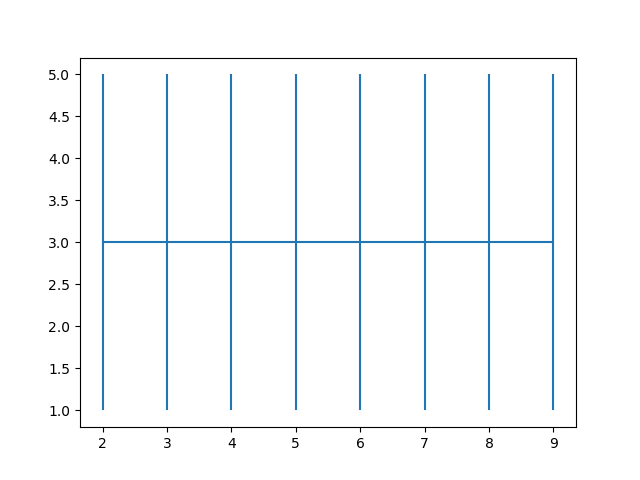

k = 2
k = 2


In [44]:
# Plot data
plt.figure()
plt.errorbar(range(2,len(gaps)+2), gaps, yerr=error)
plt.show()

# Get best k
k = define_k(gaps, error)

<IPython.core.display.Javascript object>


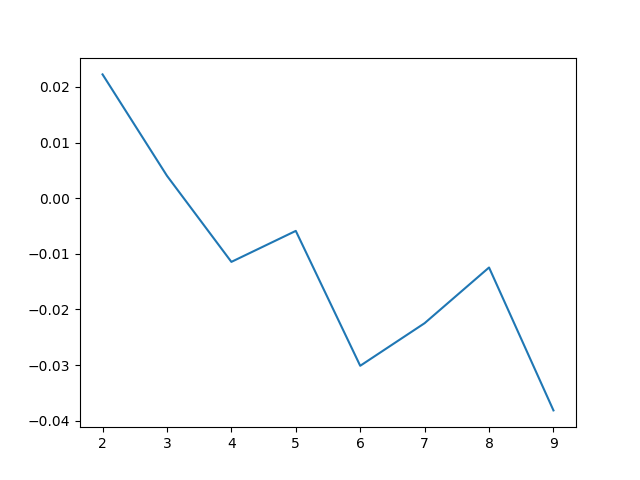

k = 2


In [45]:
# Plot data
plt.figure()
plt.plot(range(2,len(sils)+2), sils)
plt.show()

# Get best k
k = np.argmax(np.asarray(sils))+2
print("k = %d" % k)

<IPython.core.display.Javascript object>


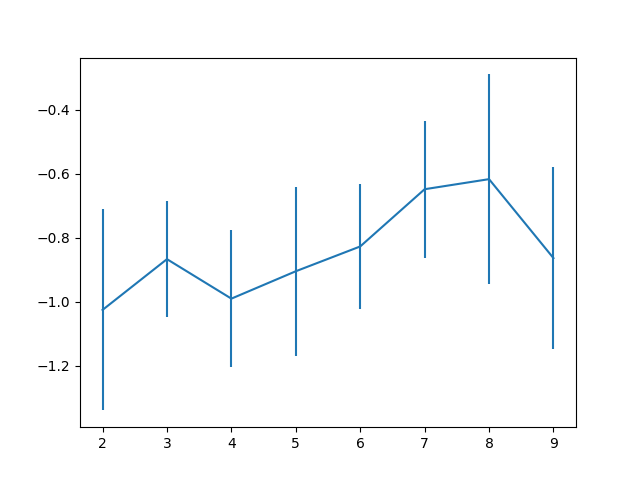

k = 8
CPU times: user 120 ms, sys: 214 µs, total: 120 ms
Wall time: 129 ms


In [46]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence)+2), coherence, yerr=coherence_std)
# plt.show()

# Get best k
k = np.argmax(np.asarray(coherence))+2
# k = get_curve_knee(range(1,len(coherence)+1), coherence)
print("k = %d" % k)

<IPython.core.display.Javascript object>


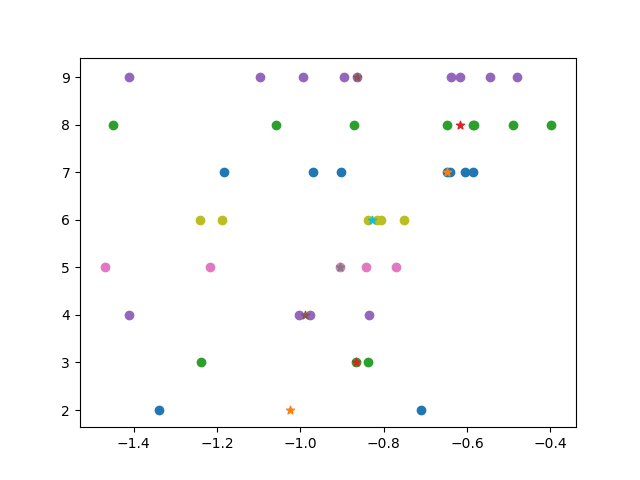

-1.0251487557
-0.866657976878
-0.989920274849
-0.904444503191
-0.827043619354
-0.648387951488
-0.616972764866
-0.863412258062


In [47]:
plt.figure()
for idx, i in enumerate(coherence_array):
    median = np.median(i)
    print(median)
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")

In [48]:
import pickle

with open("clustering_bcc.pkl", "wb") as pklfile:
    pickle.dump(df, pklfile)